# Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from sklearn.datasets import make_circles, make_blobs

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
def get_simple():
    X, y = make_blobs(centers=[[-1.5, -1.5], [1.5, 1.5]], n_samples=100, random_state=42)
    y[y == 0] = -1
    return X, y

def get_difficult():
    X, y = make_circles(n_samples=200, noise=0.2, factor=0.5, random_state=42)
    y[y == 0] = -1
    return X, y

In [4]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = np.min(x) - 0.1 * np.abs(np.min(x)), np.max(x) + 0.1 * np.abs(np.max(x))
    y_min, y_max = np.min(y) - 0.1 * np.abs(np.min(y)), np.max(y) + 0.1 * np.abs(np.max(y))
    xx, yy, = np.mgrid[x_min:x_max:h, y_min:y_max:h]
    return xx, yy

def plot_contours(ax, svm, xx, yy, **params):
    # Mesh samples.
    X_mesh = np.c_[xx.ravel(), yy.ravel()]

    # Compute decision values for mesh samples.
    Z = svm.decision_function(X_mesh)
    Z = Z.reshape(xx.shape)

    # Plot contours.
    out = ax.contourf(xx, yy, Z, **params)

    # Plot decision boundary.
    out = ax.contour(xx, yy, Z, [-.1, .1], vmin=-.012, vmax=.012, linewidths=[2, 2])
    return out

### **1. Training of SVMs via Constrained Optimization** <a class="anchor" id="optim"></a>

Throughout this notebook, we assume $\mathbf{X} \in \mathbb{R}^{N \times D}$ as $N \times D$ matrix of training examples and $\mathbf{t} \in \{-1, +1\}^N$ as $N$-dimensional vector of training targets (i.e., **binary** class labels).
To express the dual SVM in standard form, we first have to express the kernel matrix $K \in \mathbb{R}^{NxN}$ such that each entry is $K_{ij} = k(\mathbf{x}_i , \mathbf{x}_j)$. For convenience of notation, we introduce a $N \times N$ matrix with zeros everywhere except on the diagonal, where we store the labels, that is, $\mathbf{T} = \text{diag}(\mathbf{t})$.

The dual form of the SVM was introduced as:
\begin{align}
   \widetilde{L}(\mathbf{a}) = \sum\limits_{n=1}^N a_n - \frac{1}{2} \sum\limits_{n=1}^N \sum\limits_{m=1}^N a_n a_m t_n t_m k (\mathbf x _n,\mathbf x _m) \\
\end{align}

To simplify the mathematical procedure, we transform it into matrix multiplication form:
\begin{align*}
\widetilde{L}(\mathbf{a}) = \mathbf{1}^\mathrm{T}_{N} \boldsymbol{a} - \frac{1}{2} \boldsymbol{a}^\mathrm{T} \mathbf{T} \mathbf{K} \mathbf{T} \boldsymbol{a}
\end{align*}
where  $\mathbf{1}_N$ denotes an $N$-dimensional vector of ones.

The optimization objective is given by:
$\begin{align}
\max_{\boldsymbol{a}}\widetilde{L}(\mathbf{a})
\end{align}
$
subject to
$$
\begin{equation*}
0 \leqslant a_n \leqslant C, \\
\sum\limits_{n=1}^N a_n t_n = 0.
\end{equation*}$$

Since there are many different possible views of the SVM, there are many approaches for solving the resulting optimization
problem.  The approach presented and to be implemented here, expressing the SVM problem in standard convex optimization form, is not often used in practice. However, more sophisticated optimization algorithms would be out of the scope of this exercise.

Once, we have found the optimum $\boldsymbol{a}$, the decision function of the SVM is given by
\begin{equation}
d(\mathbf{x}) = \sum_{n=1}^N a_n y_n k(\mathbf{x}_n, \mathbf{x}) + b,
\end{equation}
where $b \in \mathbb{R}$ is the bias parameter. We can compute it according to
\begin{equation}
b = \frac{1}{N_\mathcal{M}} \sum_{n \in \mathcal{M}} \left(y_n - \sum_{m \in \mathcal{S}} a_m y_m k(\mathbf{x}_n, \mathbf{x}_m)\right),
\end{equation}
where $\mathcal{S} \subseteq \{1, \dots, N\}$ denotes the set of support vectors and $\mathcal{M} \subseteq \{1, \dots, N\}$ denotes the set of support vectors lying
on the margin with $N_\mathcal{M} = |\mathcal{M}|$.

Finally, we can make predictions according to
\begin{equation}
y(\mathbf{x}) = \text{sign}(d(\mathbf{x})).
\end{equation}

> Below, implement a $C$-SVM for binary classification by solving the dual problem above.
> For optimization make use of `scipy` and its [Optimization Module](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html#sequential-least-squares-programming-slsqp-algorithm-method-slsqp).

In [10]:
class LinearKernel:
    def __call__(self, X_1, X_2):
        """Computes linear kernel matrix between X_1 and X_2.

        Args:
            X_1 (array-like): Input samples in shape (N, D).
            X_2 (array-like): Input samples in shape (N, D).

        Returns:
            ndarray: Kernel matrix of shape shape (N, M)
        """
        return X_1 @ X_2.T

In [11]:
class RBFKernel:
    def __init__(self, gamma=1):
        """Computes RBF kernel matrix between X_1 and X_2.

        Args:
            gamma (float): Hyperparameter of RBF kernel.
        """
        self.gamma = gamma

    def __call__(self, X_1, X_2):
        """Computes the kernel matrix.

        Args:
            X_1 (array-like): Input samples in shape (N, D).
            X_2 (array-like): Input samples in shape (N, D).

        Returns:
            ndarray: Kernel matrix of shape shape (N, M)
        """
        # Compute pairwise squared Euclidean distances.
        norm = np.array([[np.linalg.norm(x1, x2) for x1 in X_1] for x2 in X_2])
        return np.exp(-norm / 2 * self.gamma **2)


In [45]:
class SVM:
    def __init__(self, kernel_func, C=1.0, random_state=42):
        """Implementation of a C-SVM for binary classification.
        Args:
            C (float): Regularization parameter. The strength of the regularization is inversely
                proportional to C. Must be strictly positive. (default=1.0)
            kernel_func (callable): Specifies the kernel type to be used in the algorithm.
            random_state (int): Random state to ensure reproducibility when initializing  a values.
        """
        self.kernel = kernel_func
        self.C  = C
        self.random_state = random_state


    def fit(self, X, t):
        """Fit the SVM model according to the given training data.

        Args:
            X (array-like): Training samples of shape (N, D).
            t (array-like): Training targets of shape (N).

        Returns:
            self: The fitted SVM object.
        """

        N = X.shape[0]
        K = self.kernel(X, X)
        T = np.diag(t)
        ones_N = np.ones(N)

        # Initialize lagrange multipliers
        np.random.seed(self.random_state)
        a0 = np.random.rand(N)

        # Optimization
        # Step 1: Define the loss function and its gradient.
        def loss(a):
            # Compute loss for given a.
            left = ones_N.T @ a
            right = a.T @ T @ K @ T @ a
            return left - 0.5 * right

        def jac(a):
            # Compute gradient of loss function w.r.t. a.
            return ones_N - T @ K @ T @ a
            
        # Step 2: Define the Constraints.
        # We need to write the contraints in matrix notation:
        # - for inequalities: Ax <= b
        # - for eqalities cx = d
        # Note that x = a in our example.
        # 'fun' in the constraints needs to be adapted such that
        # 0 <= lambda a: ....

        # Set up the constraints:
        # Example: {'type': 'eq', 'fun': lambda a: a**2, 'jac': lambda a: 2*a}
        constraints = [
            {'type': 'ineq', 'fun': lambda a: a, 'jac': lambda a: np.eye(N)},
            {'type': 'ineq', 'fun': lambda a: self.C - a, 'jac': lambda a: -np.eye(N)},
            {'type': 'eq', 'fun': lambda a: np.dot(a,t), 'jac': lambda a: t}
        ]

        # Optimize the a vector.
        self.a_ = minimize(loss, a0, jac=jac, constraints=constraints, method='SLSQP').x

        # Round a values being nearly zero to zero. (for numerical stability)
        self.a_[np.isclose(self.a_, 0)] = 0  # zero out nearly zeros
        self.a_[np.isclose(self.a_, self.C)] = self.C  # round the ones that are nearly C

        # Determine indices of support vectors.
        self.support_idx_ = np.where(self.a_ > 0)[0]            

        # Determine indices of support vectors that lie on the margin.
        self.support_idx_margin_ = np.where((self.a_ > 0) & (self.a_ < self.C))[0]

        # Determine bias parameter.
        self.bias_ = np.mean(t[self.support_idx_margin_] - np.sum(self.a_ * t * K, axis=1)[self.support_idx_margin_])

        # Store support vectors including their targets and a.
        self.x_support_vectors_ = X[self.support_idx_]
        self.t_support_vectors_ = t[self.support_idx_]
        self.a_support_vectors_ = self.a_[self.support_idx_]

        return self

    def decision_function(self, X):
        """Evaluates the decision function for the samples in X.

        Args:
            X (array-like): Input samples for which decision function is to be evaluated.

        Returns:
            ndarray: Decision values of samples in X.

        """
        K = self.kernel(X, self.x_support_vectors_)
        return np.sum(self.a_support_vectors_ * self.t_support_vectors_ * K + self.bias_, axis=1)

    def predict(self, X):
        """Perform classification on samples in X.

        Args:
            X (array-like): Input samples whose class labels are to be predicted.


        Returns:
            y (array-like): Predicted class labels of samples in X.
        """
        return np.sign(self.decision_function(X))

### **2. Classification of Linearly Separable Data Set** <a class="anchor" id="linear"></a>
In a first step, we want to investigate whether our $C$-SVM with a linear kernel is able to separate the following data set.

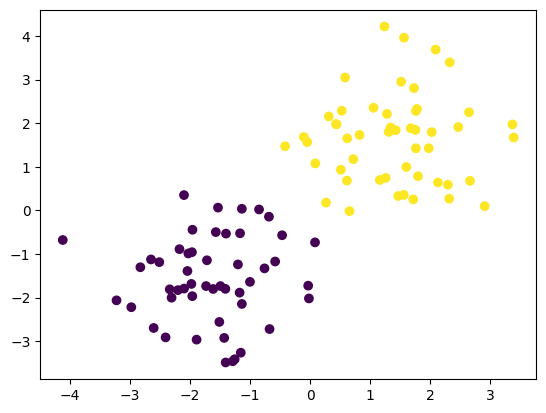

In [39]:
X, y = get_simple()
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

> Plot the decision boundary and support vectors (use `mesh_grid` and `plot_contours` which were specified above).

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/opt/miniconda3/envs/cida-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/cida-env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


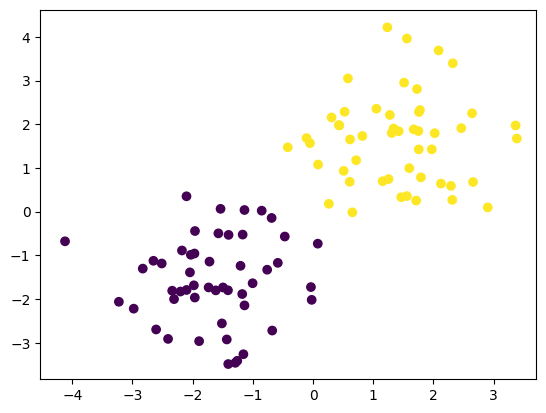

In [46]:
mesh = make_meshgrid(X[:, 0], X[:, 1])
svm = SVM(kernel_func=LinearKernel())
svm.fit(X, y)
plt.scatter(X[:, 0], X[:, 1], c=y)
plot_contours(plt, svm, *mesh, cmap=plt.cm.coolwarm, alpha=0.5)

### **3. Classification of Non-linearly Separable Data Set** <a class="anchor" id="non-linear"></a>

Before, we showed the predictive performance of our SVM on a linearly separable data set. In the second step, we generate a more difficult one instead as shown below.

In [ ]:
X, y = get_difficult()
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

We use the same setting as before to visualize the predictions of our SVM. However, this time with an RBF kernel for the non-linearly separable data set.

In [ ]:
####################
# Your Code Here   #
####################